## Importing libraries

In [4]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Using TensorFlow backend.


## Create labels
Input: Folder Path   
Output: Tuple (Label, Indices of the labels, one-hot encoded labels)

In [2]:
DATA_PATH = "./eng_data/"

def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

## Converting wave to mfcc
Input: path of file, maximum pad length(default=11)   
Output: list of mfcc vectors

In [3]:
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    try:
        mfcc = librosa.feature.mfcc(wave, sr=16000)
    except Exception as e:
        print(file_path)
        print(e)
        
    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

## Saving mfcc vectors to .npy files
Input: path to write files   

In [4]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        mfcc_vectors = []
        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label + '.npy', mfcc_vectors)

## Dividing data into training set and testing set
Input: split ratio (default=0.8)    
Output: 2 arrays of training and testing

In [5]:
def get_train_test(split_ratio=0.8):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i+1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), shuffle=True)

## Initialization by calling the necessay functions

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first (Comment next line when npy files are created to save time)
# save_data_to_array(max_len=feature_dim_2)

# Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 20
batch_size = 100
verbose = 1
num_classes = 7

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

## Creating the model

In [7]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [8]:
# Predicts a sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

## Starting the training process

In [9]:
print(X_train.shape)

(13256, 20, 11, 1)


In [10]:
model = get_model()
history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=15, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 13256 samples, validate on 3314 samples
Epoch 1/15
13256/13256 [==============================] - 41s 3ms/step - loss: 1.1219 - acc: 0.6072 - val_loss: 0.6894 - val_acc: 0.7634
Epoch 2/15
13256/13256 [==============================] - 40s 3ms/step - loss: 0.4434 - acc: 0.8489 - val_loss: 0.4341 - val_acc: 0.8488
Epoch 3/15
13256/13256 [==============================] - 38s 3ms/step - loss: 0.2765 - acc: 0.9035 - val_loss: 0.4309 - val_acc: 0.8627
Epoch 4/15
13256/13256 [==============================] - 32s 2ms/step - loss: 0.1758 - acc: 0.9400 - val_loss: 0.3629 - val_acc: 0.8871
Epoch 5/15
13256/13256 [==============================] - 38s 3ms/step - loss: 0.1055 - acc: 0.9641 - val_loss: 0.3610 - val_acc: 0.8956
Epoch 6/15
13256/13256 [==============================] - 39s 3ms/step - loss: 0.0643 - acc: 0.9799 - val_loss: 0.3418 - val_acc: 0.9013
Epoch 7/15
13256/13256 [==============================] - 39s 3ms/step - loss: 0.0371 - acc: 0.9885 - val_loss: 0.4298 - val_acc:

## Model visualized

In [12]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [35]:
!jt -r

Reset css and font defaults in:
/home/subtleseeker/.jupyter/custom &
/home/subtleseeker/.local/share/jupyter/nbextensions


/home/subtleseeker/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


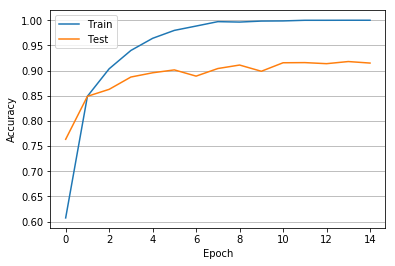

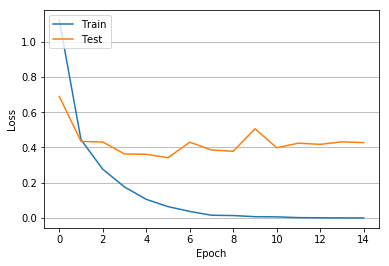

In [5]:
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# # plt.title('Training')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# ax = plt.axes()        
# ax.yaxis.grid()
# plt.show()


# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# # plt.title('Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# ax = plt.axes()        
# ax.yaxis.grid()
# plt.show()

# summarize history for accuracy
plt.plot(h['acc'])
plt.plot(h['val_acc'])
# plt.title('Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
ax = plt.axes()        
ax.yaxis.grid()
plt.show()


# summarize history for loss
plt.plot(h['loss'])
plt.plot(h['val_loss'])
# plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
ax = plt.axes()        
ax.yaxis.grid()
plt.show()

In [20]:
print("Accuracy")
for i,j in enumerate(zip(history.history['acc'], history.history['val_acc'])):
    acc = j[0]*100
    val_acc = j[1]*100
    print(i+1,acc.round(decimals=2),val_acc.round(decimals=2))
    
print()

print("Loss")
for i,j in enumerate(zip(history.history['loss'], history.history['val_loss'])):
    acc = j[0]*100
    val_acc = j[1]*100
    print(i+1,acc.round(decimals=2),val_acc.round(decimals=2))

Accuracy
1 60.72 76.34
2 84.89 84.88
3 90.35 86.27
4 94.0 88.71
5 96.41 89.56
6 97.99 90.13
7 98.85 88.9
8 99.72 90.4
9 99.64 91.1
10 99.83 89.86
11 99.86 91.55
12 99.99 91.58
13 99.99 91.37
14 100.0 91.79
15 100.0 91.49

Loss
1 112.19 68.94
2 44.34 43.41
3 27.65 43.09
4 17.58 36.29
5 10.55 36.1
6 6.43 34.18
7 3.71 42.98
8 1.53 38.54
9 1.35 37.82
10 0.71 50.6
11 0.62 39.85
12 0.18 42.42
13 0.09 41.75
14 0.02 43.19
15 0.01 42.75


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 19, 10, 32)        160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 19, 10, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 9, 48)         6192      
_________________________________________________________________
batch_normalization_11 (Batc (None, 18, 9, 48)         192       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 17, 8, 120)        23160     
_________________________________________________________________
batch_normalization_12 (Batc (None, 17, 8, 120)        480       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 4, 120)         0         
__________

In [28]:
# A nice method to check all the attributes of an object
from pprint import pprint
pprint(vars(model))

{'_built': True,
 '_collected_trainable_weights': [<tf.Variable 'conv2d_11/kernel:0' shape=(2, 2, 1, 32) dtype=float32_ref>,
                                  <tf.Variable 'conv2d_11/bias:0' shape=(32,) dtype=float32_ref>,
                                  <tf.Variable 'batch_normalization_10/gamma:0' shape=(32,) dtype=float32_ref>,
                                  <tf.Variable 'batch_normalization_10/beta:0' shape=(32,) dtype=float32_ref>,
                                  <tf.Variable 'conv2d_12/kernel:0' shape=(2, 2, 32, 48) dtype=float32_ref>,
                                  <tf.Variable 'conv2d_12/bias:0' shape=(48,) dtype=float32_ref>,
                                  <tf.Variable 'batch_normalization_11/gamma:0' shape=(48,) dtype=float32_ref>,
                                  <tf.Variable 'batch_normalization_11/beta:0' shape=(48,) dtype=float32_ref>,
                                  <tf.Variable 'conv2d_13/kernel:0' shape=(2, 2, 48, 120) dtype=float32_ref>,
              

## Prediction

In [29]:
print(predict('./eng_data/left/1cc80e39_nohash_0.wav', model=model))

left


## Confidence

In [30]:
def confidence(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    u = model.predict(sample_reshaped)
#     print(u)
    return u, get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [31]:
labs = get_labels()[0]

In [32]:
confs, word = confidence('./eng_data/left/1cc80e39_nohash_0.wav', model=model)
for lab,conf in zip(labs,confs[0]):
    print(lab , "    " ,conf)
print(word)

down      3.5824613e-16
go      3.0647503e-12
left      1.0
on      1.160079e-13
right      4.758897e-09
up      3.4712777e-10
yes      1.6291062e-11
left


In [33]:
def confidence(new_sample, model):

    new_sample = new_sample.reshape(-1)
    # print("Ye: " + str(new_sample.shape))
    sample = array2mfcc(new_sample)
    sample_reshaped = sample.reshape(1,20,11,1)
    return model.predict(sample_reshaped)


def get_conf(inp, model):
    labs = get_labels()[0]
    inp = np.array(inp)
    confs = confidence(inp, model=model)
#     print("zzz")
#     print(confs[0])
#     print(labs)
    for lab,conf in zip(labs,confs[0]):
        print(lab , "    " ,conf)
    # print(word)
    
def get_conf2(sample, model):
    for a,b in zip(get_labels()[0], model.predict(sample)[0]):
        print(a, "     ", b)


In [34]:
# for i in model.predict(sample_reshaped)[0]:
#     print(i)
# model.predict(sample_reshaped)[0]

# Testing the model in realtime

In [35]:
import sounddevice as sd
import time

## Converting the recorded array to mfcc
Instead of recording speech into a file and reading from it to create an array, this function would directly convert the recorded array into mfcc coefficients.

In [36]:
def array2mfcc(wave, max_len=11):
    sr = 16000
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [37]:
## For reference: These are the words trained to the classifier 
get_labels()[0]

['down', 'go', 'left', 'on', 'right', 'up', 'yes']

## Recording...
Please speak after executing the next cell.   

In [42]:
duration = 1  # seconds
fs = 16000
new_sample = sd.rec(int(duration * fs), samplerate=fs, channels=1)
time.sleep(duration)
sd.play(new_sample, fs)

In [43]:
new_sample = new_sample.reshape(-1)
sample = array2mfcc(new_sample)
sample_reshaped = sample.reshape(1,20,11,1)

print(get_labels()[0][np.argmax(model.predict(sample_reshaped))])
get_conf2(sample_reshaped, model)

go
down       0.00019802894
go       0.91213584
left       7.179345e-05
on       0.0728288
right       0.014749701
up       1.5815662e-05
yes       1.6174128e-07


In [ ]:
..stop..

## Saving classifier

In [48]:
model_json = model.to_json()

In [49]:
with open("model73.json", "w") as json_file:
    json_file.write(model_json)

In [50]:
model.save_weights("model73.h5")

In [22]:
import pickle
with open("history73", "wb") as f:
    pickle.dump(history.history, f)

## Loading classifier

In [1]:
from keras.models import model_from_json
# load json and create model
json_file = open('model73.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("model73.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [2]:
import pickle
with open("history73", "rb") as f:
    h = pickle.load(f)